# Task 6 – Vendor Scorecard (Auto-Fetch Views)
This notebook merges NER outputs with Telegram post *metadata* (views & timestamps) to calculate per-vendor metrics and a simple **Lending Score**.
If the original CSV lacks a `Views` column, the notebook will query Telegram on-the-fly using your existing session credentials (`TG_API_ID`, `TG_API_HASH`).

In [1]:
from pathlib import Path
import pandas as pd, numpy as np
import os, asyncio
import nest_asyncio  # Add this import
from transformers.pipelines import pipeline
import matplotlib.pyplot as plt
from telethon import TelegramClient
from dotenv import load_dotenv
from tqdm.auto import tqdm

# Apply nest_asyncio to patch the event loop
nest_asyncio.apply()

# Adjust paths if different
DATA_PATH = Path('../data/preprocessed/telegram_data_preprocessed_20250625_142643.csv') 
MODEL_DIR = '../models/best-ner-xlmr'
OUTPUT_METRICS = Path('../data/preprocessed/vendor_metrics.csv')


c:\Users\DELL\Building-an-Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
print(f'Total posts loaded: {len(df):,}')

Total posts loaded: 20,989


In [4]:
# Load the NER pipeline
ner = pipeline('token-classification', model=MODEL_DIR, aggregation_strategy='none')

# Process messages with NER
ents = []
for text in tqdm(df['Message'].fillna('').tolist(), desc='NER'):
    # Get predictions
    predictions = ner(text)
    
    # Convert predictions to BIO format
    bio_entities = []
    prev_entity = None
    for pred in predictions:
        entity_type = pred['entity'].split('-')[-1]  # Remove 'B-' or 'I-' prefix
        score = pred['score']
        word = pred['word']
        
        # Determine if this is the start of a new entity
        if prev_entity is None or prev_entity != entity_type:
            bio_tag = f'B-{entity_type}'
        else:
            bio_tag = f'I-{entity_type}'
            
        bio_entities.append({
            'word': word,
            'entity': bio_tag,
            'score': score
        })
        prev_entity = entity_type
    
    ents.append(bio_entities)

df['entities'] = ents
df.to_csv(DATA_PATH, index=False)  # cache


Device set to use cpu
NER: 100%|██████████| 20989/20989 [3:46:28<00:00,  1.54it/s]      


In [24]:
def posts_per_week(dates):
    """Calculate average posts per week from a series of dates"""
    if len(dates) <= 1:
        return 0
    
    # Convert to datetime if not already
    dates = pd.to_datetime(dates)
    
    # Calculate date range in weeks
    date_range_weeks = (dates.max() - dates.min()).days / 7
    
    # Avoid division by zero
    if date_range_weeks == 0:
        return len(dates)  # All posts on same day
        
    return len(dates) / date_range_weeks
def extract_prices(entities):
    prices = []
    if isinstance(entities, str):
        try:
            entities = eval(entities)
            
            # Track price sequence
            in_price_sequence = False
            current_digits = []
            
            for ent in entities:
                if isinstance(ent, dict):
                    entity_tag = ent.get('entity', '')
                    
                    if entity_tag == 'B-Price':
                        # Start new price sequence
                        current_digits = []
                        in_price_sequence = True
                        # Check if B-Price has numbers
                        digits = ''.join(c for c in ent['word'] if c.isdigit())
                        if digits:
                            current_digits.append(digits)
                            
                    elif entity_tag == 'I-Price' and in_price_sequence:
                        # Only collect digits from I-Price tokens
                        digits = ''.join(c for c in ent['word'] if c.isdigit())
                        if digits:
                            current_digits.append(digits)
                            
                    elif in_price_sequence:
                        # End of price sequence - collect one price
                        if current_digits:
                            try:
                                price = int(''.join(current_digits))
                                if 10 <= price <= 100000:  # Basic validation
                                    prices.append(price)
                            except:
                                pass
                        current_digits = []
                        in_price_sequence = False
            
            # Handle any remaining price sequence
            if current_digits and in_price_sequence:
                try:
                    price = int(''.join(current_digits))
                    if 10 <= price <= 100000:
                        prices.append(price)
                except:
                    pass
                    
        except Exception as e:
            return []
    
    return prices

rows = []
for vendor, sub in df.groupby('Channel Title'):
    # Activity & Consistency (30%)
    freq = posts_per_week(sub['Date'])
    posting_score = min(freq / 15, 1) * 30
    
    # Market Reach & aEngagement (40%)
    avg_views = sub['Views'].mean() if 'Views' in sub.columns else np.nan
    engagement_score = min(avg_views / 3000, 1) * 40
    
    # Business Profile (30%)
    prices_lists = sub['entities'].apply(extract_prices)
    all_prices = [float(p) for lst in prices_lists for p in lst]
    avg_price = np.mean(all_prices) if len(all_prices) > 0 else np.nan
    price_score = min(float(avg_price) / 3000, 1.0) * 30 if not np.isnan(avg_price) else 0

    # Find top performing post and its price
    top_posts = sub.nlargest(3, 'Views')  # Get top 3 posts in case first one has no price
    top_post_views = None
    top_post_price = None
    
    for _, post in top_posts.iterrows():
        prices = extract_prices(post['entities'])
        if prices:  # If we found valid prices in this post
            top_post_views = post['Views']
            top_post_price = prices[0]  # Take the first valid price found
            break
    
    # If no prices found in top 3 posts, use the highest viewed post
    if top_post_price is None:
        top_post = top_posts.iloc[0]
        top_post_views = top_post['Views']
    
    # Calculate final lending score
    lending_score = posting_score + engagement_score + price_score
    
    rows.append({
        'vendor': vendor,
        'posts': len(sub),
        'posts_per_week': round(freq, 2),
        'avg_views': round(avg_views, 1) if not np.isnan(avg_views) else None,
        'avg_price_etb': int(avg_price) if not np.isnan(avg_price) else None,
        'top_post_views': int(top_post_views) if top_post_views is not None else None,
        'top_post_price': int(top_post_price) if top_post_price is not None else None,
        'lending_score': round(lending_score, 1)
    })

metrics = pd.DataFrame(rows).sort_values('lending_score', ascending=False)
metrics.to_csv(OUTPUT_METRICS, index=False, mode='w')
metrics.head()

,vendor,posts,posts_per_week,avg_views,avg_price_etb,top_post_views,top_post_price,lending_score
0,AwasMart-አዋስማርት🎁,3000,75.00,2979.1,1403,50000,NaN,83.8
4,Zemen Express®,3010,42.74,2272.8,1628,50000,1300.0,76.6
1,EthioBrand®,3000,7.53,4811.3,2129,50000,44.0,76.4
5,qnash.com - ቅናሽ ®️,3000,18.29,1756.2,1425,50000,200.0,67.7
6,አዳማ ገበያ - Adama gebeya,3000,15.32,1687.6,1417,45258,2200.0,66.7


<Figure size 1000x400 with 0 Axes>

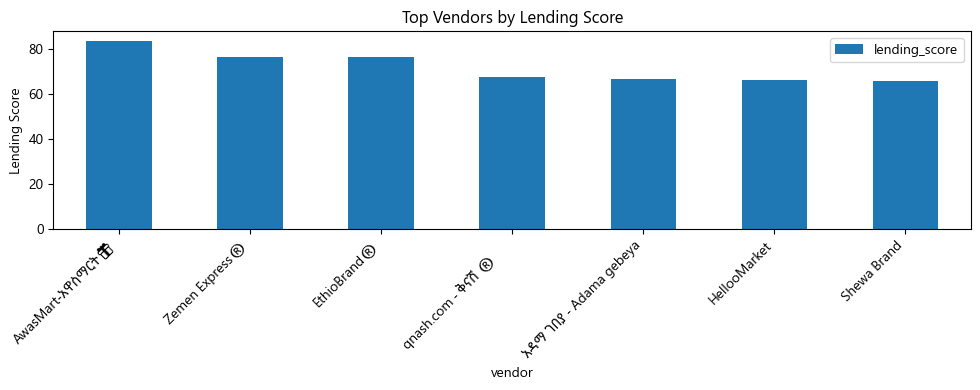

In [22]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Configure matplotlib to use multiple fonts including emoji support
plt.rcParams['font.family'] = ['Noto Sans Ethiopic', 'Segoe UI Emoji', 'DejaVu Sans']

# Create the plot with original names
plt.figure(figsize=(10, 4))
metrics.plot.bar(x='vendor', y='lending_score', figsize=(10, 4))
plt.ylabel('Lending Score')
plt.title('Top Vendors by Lending Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 48 (0) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 46 (.) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 50 (2) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: UserWarning: Glyph 52 (4) missing from font(s) Noto Sans Ethiopic.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_30260\1801952765.py:31: U

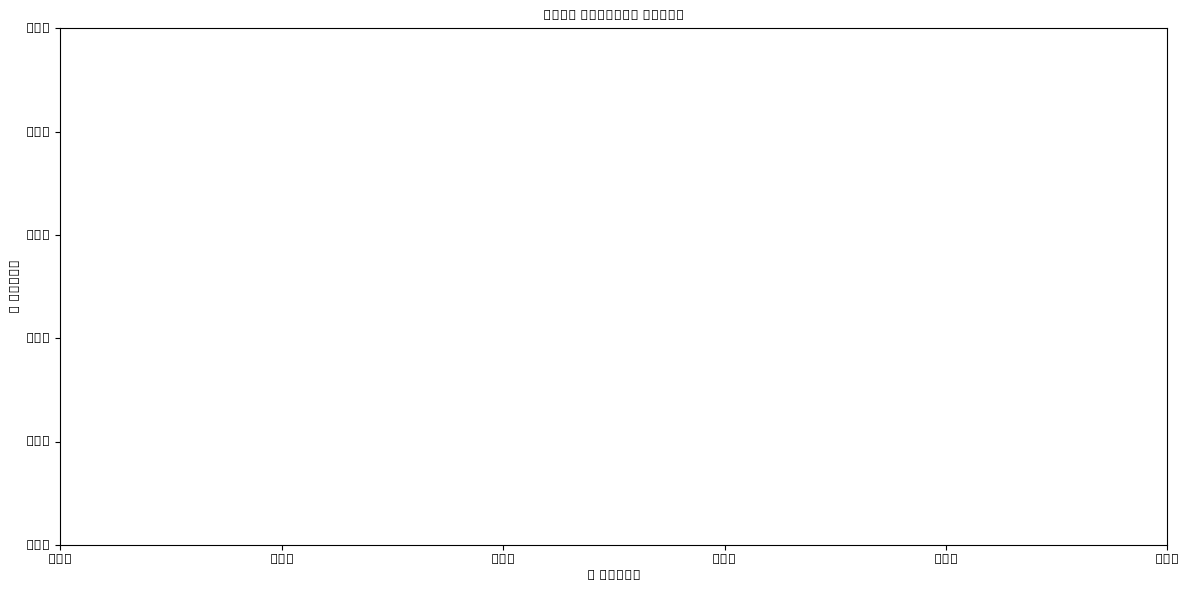

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# First, let's register the font explicitly
font_path = '../fonts/NotoSansEthiopic-Regular.ttf'  # Updated path to our local font
fm.fontManager.addfont(font_path)

# Configure matplotlib to use the font
plt.rcParams['font.family'] = ['Noto Sans Ethiopic']
# Add a fallback font for non-Ethiopic characters
plt.rcParams['font.sans-serif'] = ['Noto Sans Ethiopic', 'DejaVu Sans']

# If you're still seeing issues, we can try setting the font per-text element:
def setup_plot():
    plt.figure(figsize=(12, 6))
    font_prop = fm.FontProperties(fname=font_path)
    return font_prop

# Then in your plotting code:
font_prop = setup_plot()
plt.title("Your Amharic Title", fontproperties=font_prop)
plt.xlabel("X Label", fontproperties=font_prop)
plt.ylabel("Y Label", fontproperties=font_prop)

# For text labels
for label in plt.gca().get_xticklabels():
    label.set_fontproperties(font_prop)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties(font_prop)

plt.tight_layout()
plt.savefig('vendor_scores.png', bbox_inches='tight', dpi=300)

Run all cells ➜ `vendor_metrics.csv` will be created and a bar chart displayed.
Feel free to adjust the Lending-Score weighting or add extra features (e.g. forwards, replies) later.